_This notebook started out as a direct iPython translation of the **M7 PDR05 Excel Spreadsheet**, implemented in a similar way as originally done by **Juande Santander-Vela** in his separate analysis of the M7 Milestone PDR05 (MS Word) document._

_This is an interactive document. **sympy** and **astropy** are required to evaluate some of the blocks of code. While overlapping in scope with "Full Computational Requirements for SDP.ipynb" and "Parametric Models of SDP Compute Requirements.ipynb", this document was independently derived._ 

_Equations may be evaluated for the different telescopes and imaging modes, either numerically or symbolically_ 

_The owner of this notebook document is **Francois Malan** of Space Advisory Company._

# 1. Definitions:

_If any of these values need to be changed, this should be done in the "Implementation" section lower down. The display-formatted text in this "Definitions" section is (as you may have guessed) just for display purposes._ 

**Output Parameters we are interested in:**

|**Symbol**|**Python**|**Description**|
|-|-|-|
| $M_{buf,vis}$ | Mbuf_vis | Buffer size (bytes) |
| $M_{w,cache}$ | Mw_cache | w-convolution kernel cache size |
| $N_{pix,linear}$ | Npix_linear | The linear number of pixels along the image's side (assumed to be square)|
| $R_{FLOP}$ | Rflop | Overall flop rate |
| $R_{IO}$ | Rio | Overall I/O rate, (bytes/s) |

** Physical constants **

|**Symbol**|**Python**|**Value**|**Description**|
|-|-|-|-|
| $c$ | u.c | $2.99792458 \times 10^8$ (m/s) | Speed of light in a vacuum |
| $\Omega_E$ | Omega_E | $7.292115 \times 10^{-5}$ (rad/s) | Angular rotational velocity of the Earth relative to the fixed stars |
| $R_{Earth}$ | R_Earth | $6.378136 \times 10^6$ (m) | Radius of the Earth |

**Global parameters - used for all telescopes**

*May need global tweaking*

|**Symbol**|**Python**|**Value**|**Description**|
|-|-|-|-|
| $\epsilon_{w}$ | epsilon_w | 0.01 | Amplitude level of w-kernels to include. Value 0.01 is used in [RD6] where it is shown to give kernel sizes in rough agreement with CASA package.|
| $M_{vis}$| Mvis | 12 | Size of visibility datum in the buffer (in bytes?) |
| $N_{kernel}$ | Naa | 9 | Linear size of the combined $A$ and $W$ kernels (pixels). This size is at the low end of the range 9-15 given by [RD11] in Section 4.4.2 of their paper. |
| $N_{mm}$ | Nmm | 4| |
| $N_{pp}$ | Npp | 4| Number of polarisation products that are processed |
| $N_{w}$ | Nw | 2| Bytes per value |
|$Q_{bw}$|Qbw|1 |Bandwidth quality factor, determining how well bandwidth smearing can be controlled|
|$Q_{fcw}$|Qfcw|10|Number of adjacent frequency channels for which baseline dependent kernels can be reused|
|$Q_{GCF}$|Qgcf|8|Oversampling factor of w-convolution kernels|
|$Q_{w}$|Qw|1 | Quality factor for w-projection correction. Value 1 corresponds to correction of maximal w values.  For comparison [RD7] uses values 0.1—0.3 |
| $T_{ion}$ | T_ion | 60 | Ionospheric timescale |

** Telescope-dependent parameters **

*Subject to change*

|***Telescope parameters***
|-|-|-|-|-|-|
| | Symbol | Python | **SKA1-Low** | **SKA1-Mid** | **SKA1-Survey** |
| Maximum baseline according to SKAO (km)     | $B_{max}$|Bmax| $100$|$200$|$50$|
| Antenna/Station Diameter (m)                                   |$D_{s}$|Ds|$35$|$15$|$15$|
| Minimum frequency (of the chosen band) | $f_{min}$ | freq_min | 50 Mhz | depends on band | depends on band |
| Maximum frequency (of the chosen band) | $f_{max}$ | freq_max | 350 Mhz | depends on band | depends on band |
| Number of stations/antennas                                    |$N_{a}$|Na|$1024$|$256$|$96$|
| Number of beams                                                |$N_{beam}$|Nbeam|$1$|$1$|$36$|
| Number of frequency channels from corellator                   |$N_{f,max}$|Nf_max|$256000$|$256000$|$256000$|
| Correlator dump time appropriate for $B_{max,ref}$ (seconds) |$T_{dump,ref}$|Tdump_ref|$0.6$|$0.08$|$0.3$|
| Bins (upper bounds) used for discretizing baseline distribution in computations (km) | - | baseline_bins | $(4.9, 7.1, 10.4, 15.1, 22.1, 32.2, 47.0, 68.5, 100)$ | $(4.4, 6.7, 10.3, 15.7, 24.0, 36.7, 56.0, 85.6, 130.8, 200)$ | $(3.8, 5.5, 8.0, 11.5, 16.6, 24.0, 34.6, 50)$ 
| Number of baselines in each bin | - | baseline_bin_counts | $(5031193, 732481, 796973, 586849, 1070483, 939054, 820834, 202366, 12375)$ | $(669822, 61039, 64851, 66222, 70838, 68024, 74060, 68736, 21523, 745)$ | $(81109, 15605, 15777, 16671, 16849, 17999, 3282, 324)$ 

** Spectral vs Continuum vs Fast Imaging (i.e. slow transients) **

*This is the same for all telescopes and bands*, but may be overwritten by HPSOs

|***Imaging-mode telescope parameters***
|-|-|-|-|-|-|
| | Symbol | Python | **Continuum** | **Spectral** | **SlowTrans** |
| Baseline length that (Fbshort+Fbmid), i.e. 90% of baselines are shorter than | $B_{lim,mid}$ | Blim_mid | $20000$ | n/a | $20000$
| Number of output map channels | $N_{f, out}$ | Nf_out | $500$ | *computed* | $500$ |
| Number of channels for gridding at longest baseline | $N_{f, used}$ | Nf_used | *computed* | *computed* | *computed*|
| Number of major CLEAN cycles to be done | $N_{major}$ | Nmajor | $10$ | $1$ | $1$ |
| Field of view factor | $Q_{FoV}$| Qfov | $1.8$ | $1$ | $0.9$ |
| Quality factor defining the oversampling of synthesised beam | $Q_{pix}$ | Qpix | $2.5$ | $2.5$ | $1.5$|
| Observation length |$T_{obs}$ | Tobs  | $6\ {\rm h}$  | $6\ {\rm h}$ | $1.2\ {\rm sec}$  |
| Snapshot timescale implemented (sec) | $T_{snap}$ | Tsnap | *optimized* | *optimized* | *optimized* |
| Minimum Snapshot timescale - equals $T_{obs}$ for slow transients | $T_{snap, min}$ | Tsnap_min | $1.2\ {\rm sec}$ | $1.2\ {\rm sec}$ | $1.2\ {\rm sec}$

# 2. Load Implementation & Environment (refer to .py source files):

In [1]:
'''
The following command imports the python modules, methods and code fragments that are required to run this notebook. 
Please refer to the following python files for implementation details (omitted here for readability)
* api.py -- contains several convenience / interface methods for interacting with the parametric model in Python
* api_ipython.py -- extends api.py with functionality specific to the iPython notebook, such as plotting
* parameter_definitions.py -- contains definitions of variables, primary telescope parameters  
* equations.py -- contains equations for computing secondary telescope-specific parameters from input parameters
* implementation.py -- contains methods for performing computations (i.e. crunching the numbers)
'''
from equations import Equations as f  # Letter f is used because class used to be called "Formulae"
from parameter_definitions import *
from parameter_definitions import ParameterDefinitions as p
from parameter_definitions import Constants as c
from implementation import Implementation as i
from api import SKAAPI as api

In [2]:
import time
t0 = time.time()
tel = Telescopes.SKA1_Low
band = Bands.Low
mode = ImagingModes.Spectral
if not i.telescope_and_band_are_compatible(tel, band):
    raise AssertionError("The supplied telescope and band are not compatible with each other!")
telescope_parameters = i.calc_tel_params(tel, mode, band=band)
(Tsnap_opt, Nfacet_opt) = i.find_optimal_Tsnap_Nfacet(telescope_parameters, verbose=True)
print (Tsnap_opt, Nfacet_opt)
#(Tsnap_opt, Nfacet_opt) = (87.16, 3)
t1 = time.time()
expression = telescope_parameters.Rflop
expression_subst = expression.subs({telescope_parameters.Tsnap : Tsnap_opt, telescope_parameters.Nfacet : Nfacet_opt})
result = i.evaluate_binned_expression(expression_subst, telescope_parameters)
print 'Result of expression = %f Peta' % (result / c.peta)
t2 = time.time()
print 'Optimization took %f seconds' % (t1-t0)
print 'Evaluation took %f seconds' % (t2-t1)
print 'Total time = %f seconds' % (t2-t0)

Evaluating Nfacets = 1
Tsnap has been optimized as : 89.467092. (Cost function = 2.007279)
Evaluating Nfacets = 2
Tsnap has been optimized as : 158.410223. (Cost function = 2.199212)

Expression increasing with number of facets; aborting exploration of Nfacets > 2

2.007279 PetaFLOPS was the lowest FLOP value, found for (Nfacet, Tsnap) = (1, 89.47)
(89.4670920898997, 1)
Result of expression = 2.007279 Peta
Optimization took 2.881000 seconds
Evaluation took 0.120000 seconds
Total time = 3.001000 seconds


# 3. Computations:

## Optimizing Tsnap and Nfacet for a given band and mode:

## Looping through a list of (standard) bands -- this may take several minutes:

In [3]:
# Only loop over the first bands for each telescope (assumed to be the most demanding)
selected_bands = (Bands.Low, Bands.Mid1, Bands.Sur1)  
selected_modes = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.SlowTrans)

non_peta_values = ('Npix_linear')
values_to_take_max = ('Npix_linear')

results = {}

for telescope in (Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid_old, Telescopes.SKA1_Sur_old):
    for band in selected_bands:
        for mode in selected_modes:
            if not i.telescope_and_band_are_compatible(telescope, band):
                continue # This combination of telescope and band is not allowed. Skip.
            
            tp = i.calc_tel_params(telescope, mode, band=band)
            print '.'
            print '>> Evaluating %s, %s band in %s mode' % (telescope, band, mode)

            (Tsnap_opt, Nfacet_opt) = i.find_optimal_Tsnap_Nfacet(tp)
            print 'Optimal (Tsnap, Nfacet) values = (%.2f sec, %d)' % (Tsnap_opt, Nfacet_opt)

            substitution = {tp.Tsnap : Tsnap_opt, tp.Nfacet : Nfacet_opt}

            expressions = (tp.Rflop_conv, tp.Rflop_fft, tp.Rflop_grid, tp.Rflop_proj, tp.Rflop_phrot, tp.Rflop, tp.Mbuf_vis, tp.Mw_cache, tp.Npix_linear, tp.Rio)
            expression_strings = ('Rflop_conv', 'Rflop_fft', 'Rflop_grid', 'Rflop_proj', 'Rflop_phrot', 'Rflop','Mbuf_vis', 'Mw_cache', 'Npix_linear', 'Rio')
            key_expressions = zip(expression_strings, expressions)

            for key_expression in key_expressions: 
                key = key_expression[0]
                expression = key_expression[1]
                expression_subst = expression.subs(substitution)
                take_max = (key in values_to_take_max)                
                result = i.evaluate_binned_expression(expression_subst, tp, take_max=take_max)
                
                # Results are listed by band, mode and evaluated expression.
                # In this case the band unqiuely identifies the telescope, therefore the telescope is not recorded separately.
                results[(band, mode, key)] = result

                if key in non_peta_values:
                    print '-> %s : %s = %g' % (mode, key, result)
                else:    
                    print '-> %s : %s = %.3g Peta' % (mode, key, result / c.peta)
print '\n>>> Done!'

.
>> Evaluating SKA1_Low_old, Low band in Continuum mode
Optimal (Tsnap, Nfacet) values = (36.82 sec, 2)
-> Continuum : Rflop_conv = 1.16e+15 Peta
-> Continuum : Rflop_fft = 6.81e+13 Peta
-> Continuum : Rflop_grid = 4.58e+14 Peta
-> Continuum : Rflop_proj = 4.27e+14 Peta
-> Continuum : Rflop_phrot = 1.72e+13 Peta
-> Continuum : Rflop = 2.13e+15 Peta
-> Continuum : Mbuf_vis = 4.47e+15 Peta
-> Continuum : Mw_cache = 3.67e+11 Peta
-> Continuum : Npix_linear = 10316.1
-> Continuum : Rio = 4.55e+12 Peta
.
>> Evaluating SKA1_Low_old, Low band in Spectral mode
Optimal (Tsnap, Nfacet) values = (59.51 sec, 1)
-> Spectral : Rflop_conv = 6.1e+15 Peta
-> Spectral : Rflop_fft = 1.01e+15 Peta
-> Spectral : Rflop_grid = 1.16e+16 Peta
-> Spectral : Rflop_proj = 6.26e+15 Peta
-> Spectral : Rflop_phrot = 0 Peta
-> Spectral : Rflop = 2.5e+16 Peta
-> Spectral : Mbuf_vis = 4.63e+17 Peta
-> Spectral : Mw_cache = 1.73e+13 Peta
-> Spectral : Npix_linear = 11462.3
-> Spectral : Rio = 2.68e+13 Peta
.
>> Evaluat

## Because it takes a little while to compute all results, let's just dump them out to screen:

In [4]:
results

{('Low', 'Continuum', 'Mbuf_vis'): 4467323196188577.5,
 ('Low', 'Continuum', 'Mw_cache'): 366595549682.15717,
 ('Low', 'Continuum', 'Npix_linear'): 10316.112195093652,
 ('Low', 'Continuum', 'Rflop'): 2126398285908525.2,
 ('Low', 'Continuum', 'Rflop_conv'): 1155753754729867.5,
 ('Low', 'Continuum', 'Rflop_fft'): 68097033030810.875,
 ('Low', 'Continuum', 'Rflop_grid'): 458257815327490.0,
 ('Low', 'Continuum', 'Rflop_phrot'): 17235043195171.977,
 ('Low', 'Continuum', 'Rflop_proj'): 427054639625185.25,
 ('Low', 'Continuum', 'Rio'): 4550051403525.403,
 ('Low', 'SlowTrans', 'Mbuf_vis'): 107607489601.7126,
 ('Low', 'SlowTrans', 'Mw_cache'): 178099695113.11493,
 ('Low', 'SlowTrans', 'Npix_linear'): 6189.667317056192,
 ('Low', 'SlowTrans', 'Rflop'): 73210567072138.28,
 ('Low', 'SlowTrans', 'Rflop_conv'): 17668126537881.82,
 ('Low', 'SlowTrans', 'Rflop_fft'): 21407153614871.9,
 ('Low', 'SlowTrans', 'Rflop_grid'): 34135286919384.562,
 ('Low', 'SlowTrans', 'Rflop_phrot'): 0.0,
 ('Low', 'SlowTrans'

## Summarize results (by summing for each selected band) the different modes' values:

In [5]:
summable_expressions = {'Rflop_conv', 'Rflop_fft', 'Rflop_grid', 'Rflop_proj', 'Rflop_phrot', 'Mbuf_vis', 'Rflop', 'Mw_cache', 'Rio'}
imaging_modes = {ImagingModes.Spectral, ImagingModes.Continuum, ImagingModes.SlowTrans}

results_per_band = {}
for band in selected_bands:
    #tel = band_info[band]['telescope']
    if not band in results_per_band:
        results_per_band[band] = {}
    for expression in summable_expressions:
        if not expression in results_per_band[band]:
            results_per_band[band][expression] = 0
        for mode in imaging_modes:
            assert (band, mode, expression) in results
            results_per_band[band][expression] += results[(band, mode, expression)]

results_per_band

{'Low': {'Mbuf_vis': 4.678709139396782e+17,
  'Mw_cache': 17891297134997.176,
  'Rflop': 2.7161561823504004e+16,
  'Rflop_conv': 7276563030786584.0,
  'Rflop_fft': 1098718235343915.6,
  'Rflop_grid': 1.2079273403026154e+16,
  'Rflop_phrot': 17235043195171.977,
  'Rflop_proj': 6689772111152177.0,
  'Rio': 31474990093127.113},
 'Mid1': {'Mbuf_vis': 2.1661352143431514e+17,
  'Mw_cache': 106230040143710.47,
  'Rflop': 2.49148275976642e+16,
  'Rflop_conv': 9267194514239796.0,
  'Rflop_fft': 1735314278156341.2,
  'Rflop_grid': 4673371400360399.0,
  'Rflop_phrot': 615990936464527.5,
  'Rflop_proj': 8622956468443139.0,
  'Rio': 230636460665395.5},
 'Sur1': {'Mbuf_vis': 2.922970711885559e+17,
  'Mw_cache': 879267094075998.6,
  'Rflop': 4.43841232136312e+16,
  'Rflop_conv': 2.126062662322612e+16,
  'Rflop_fft': 3159460589293528.0,
  'Rflop_grid': 5756465069762088.0,
  'Rflop_phrot': 408746274432015.4,
  'Rflop_proj': 1.3798824656917454e+16,
  'Rio': 159871903657711.88}}

## Let's plot the FLOP values

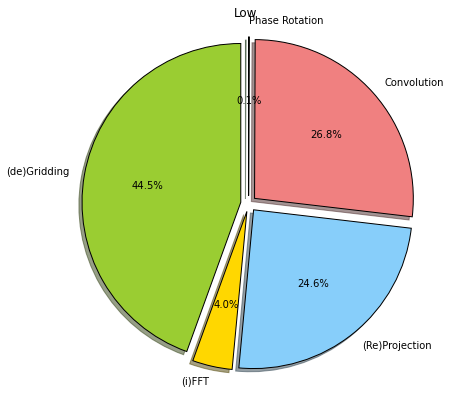

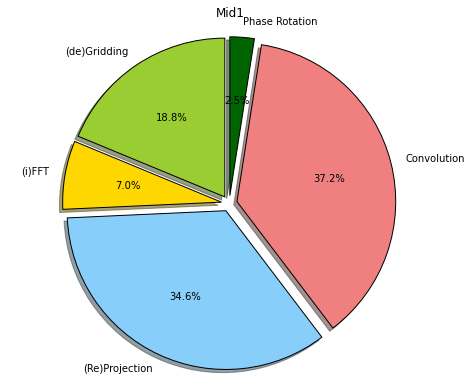

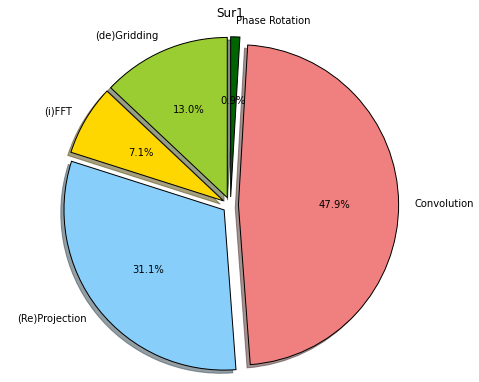

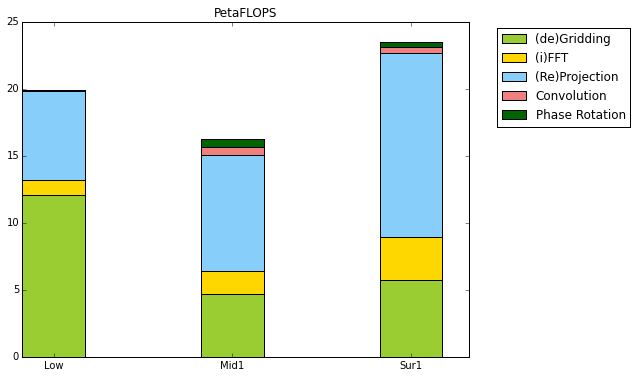

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session

results_per_tel = results_per_band
t = results_per_tel.keys()
t.sort()
for tel in t:
    values = results_per_tel[tel]

    # The slices will be ordered and plotted counter-clockwise.
    labels = '(de)Gridding', '(i)FFT', '(Re)Projection', 'Convolution', 'Phase Rotation'
    sizes = [values['Rflop_grid'], values['Rflop_fft'], values['Rflop_proj'], values['Rflop_conv'], values['Rflop_phrot']]
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'darkgreen']
    explode = (0.05, 0.05, 0.05, 0.05, 0.05) # Radial offset of the slices

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title('%s\n' % tel)

    plt.show()
    
results_per_param = {}
for tel in t:
    for param in results_per_tel[tel]:
        if not param in results_per_param:
            results_per_param[param] = []
        results_per_param[param].append(results_per_tel[tel][param])

#print results_per_param
ind = np.arange(3)

p = 'Rflop_grid'
res_grid = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_fft'
res_fft = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_proj'
res_proj = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_conv'
res_conv = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_phrot'
res_conv = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])

#Plot a stacked bar chart
width = 0.35
val = np.array(res_grid)/1e15
p1 = plt.bar(ind, val, width, color=colors[0])
bottoms = val
val = np.array(res_fft)/1e15
p2 = plt.bar(ind, val, width, color=colors[1],
             bottom=bottoms)
bottoms += val
val = np.array(res_proj)/1e15
p3 = plt.bar(ind, val, width, color=colors[2],
             bottom=bottoms)
bottoms += val
val = np.array(res_conv)/1e15
p4 = plt.bar(ind, val, width, color=colors[3],
             bottom=bottoms)
bottoms += val
val = np.array(res_conv)/1e15
p5 = plt.bar(ind, val, width, color=colors[4],
             bottom=bottoms)

plt.xticks(ind+width/2., t )
plt.title('PetaFLOPS')
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2) # legend to the right of the plot

# Doing the same for the HPSOs:

In [7]:
from equations import Equations as f  # Letter f is used because class used to be called "Formulae"
from parameter_definitions import ParameterDefinitions as p
from implementation import Implementation as i
from implementation import ParameterContainer
from sympy import Max, ceiling

#hpso_keys = ['01','02A','02B','14', '14c', '14s','22','37a','37b','38a','38b','13', '13c','13s','15','15c', '15s','27','33','37c']
#hpso_keys.sort()
hpso_keys = [HPSOs.hpso01, HPSOs.hpso02A, HPSOs.hpso02B, HPSOs.hpso14, HPSOs.hpso14c, HPSOs.hpso14s, HPSOs.hpso14sfull, 
             HPSOs.hpso22, HPSOs.hpso37a, HPSOs.hpso37b, HPSOs.hpso38a, HPSOs.hpso38b, HPSOs.hpso13, HPSOs.hpso13c,
             HPSOs.hpso13s, HPSOs.hpso15, HPSOs.hpso15c, HPSOs.hpso15s, HPSOs.hpso27, HPSOs.hpso33, HPSOs.hpso37c]
hpso_keys.sort()
HPSOs.hpso01

non_peta_values = ('Npix_linear')
values_to_take_max = ('Npix_linear')

results = {}
temp = ParameterContainer()
for hpso_key in hpso_keys:
    print '.\n>> Evaluating HPSO %s' % hpso_key
    p.apply_hpso_parameters(temp, hpso_key)
    tel = temp.telescope
    if temp.mode == 'CS':
        tpc = i.calc_tel_params(tel, ImagingModes.Continuum, hpso=hpso_key)
        tps = i.calc_tel_params(tel, ImagingModes.Spectral, hpso=hpso_key)
        (Tsnap_opt_C, Nfacet_opt_C) = i.find_optimal_Tsnap_Nfacet(tpc)
        (Tsnap_opt_S, Nfacet_opt_S) = i.find_optimal_Tsnap_Nfacet(tps)
        
        print 'Optimal (Tsnap, Nfacet) values = (%.2f sec, %d) for C and (%.2f sec, %d) for S' \
            % (Tsnap_opt_C, Nfacet_opt_C, Tsnap_opt_S, Nfacet_opt_S)
        substitution_c = {tpc.Tsnap : Tsnap_opt, tpc.Nfacet : Nfacet_opt}
        substitution_s = {tps.Tsnap : Tsnap_opt, tps.Nfacet : Nfacet_opt}

        expressions_c = (tpc.Rflop_conv, tpc.Rflop_fft, tpc.Rflop_grid, tpc.Rflop_proj, tpc.Rflop_phrot, tpc.Rflop, tpc.Mbuf_vis, tpc.Mw_cache, tpc.Npix_linear, tpc.Rio)
        expressions_s = (tps.Rflop_conv, tps.Rflop_fft, tps.Rflop_grid, tps.Rflop_proj, tps.Rflop_phrot, tps.Rflop, tps.Mbuf_vis, tps.Mw_cache, tps.Npix_linear, tps.Rio)
        expression_strings = ('Rflop_conv', 'Rflop_fft', 'Rflop_grid', 'Rflop_proj', 'Rflop_phrot', 'Rflop', 'Mbuf_vis', 'Mw_cache', 'Npix_linear', 'Rio')
        key_expressions_c = zip(expression_strings, expressions_c)
        key_expressions_s = zip(expression_strings, expressions_s)

        for index in range(len(key_expressions)):
            key_expression_c = key_expressions_c[index]
            key_expression_s = key_expressions_s[index]
            key = key_expression_c[0]
            take_max = (key in values_to_take_max)
            
            expression_c = key_expression_c[1]
            expression_s = key_expression_s[1]
            expression_subst_c = expression_c.subs(substitution_c)
            expression_subst_s = expression_s.subs(substitution_s)
            if take_max:
                result = Max(i.evaluate_binned_expression(expression_subst_c, tpc, take_max=True),
                             i.evaluate_binned_expression(expression_subst_s, tps, take_max=True))
            else:
                result = i.evaluate_binned_expression(expression_subst_c, tpc) + \
                         i.evaluate_binned_expression(expression_subst_s, tps) 
                
            results[(hpso_key, temp.mode, key)] = result
            
            if key in non_peta_values:
                print '-> hpso %s : %s = %g' % (hpso_key, key, result)
            else:    
                print '-> hpso %s : %s = %.3g Peta' % (hpso_key, key, result/1e15)        
    else:
        tp = i.calc_tel_params(tel, temp.mode, hpso=hpso_key)
        (Tsnap_opt, Nfacet_opt) = i.find_optimal_Tsnap_Nfacet(tp)
        print 'Optimal (Tsnap, Nfacet) values = (%.2f sec, %d)' % (Tsnap_opt, Nfacet_opt)
        substitution = {tp.Tsnap : Tsnap_opt, tp.Nfacet : Nfacet_opt}

        expressions = (tp.Rflop_conv, tp.Rflop_fft, tp.Rflop_grid, tp.Rflop_proj, tp.Rflop_phrot, tp.Rflop, tp.Mbuf_vis, tp.Mw_cache, tp.Npix_linear, tp.Rio)
        expression_strings = ('Rflop_conv', 'Rflop_fft', 'Rflop_grid', 'Rflop_proj', 'Rflop_phrot', 'Rflop', 'Mbuf_vis', 'Mw_cache', 'Npix_linear', 'Rio')
        key_expressions = zip(expression_strings, expressions)
        
        for key_expression in key_expressions: 
            key = key_expression[0]
            expression = key_expression[1]
            expression_subst = expression.subs(substitution)
            result = i.evaluate_binned_expression(expression_subst, tp)
            results[(hpso_key, temp.mode, key)] = result
            
            if key in non_peta_values:
                print '-> hpso %s : %s = %g' % (hpso_key, key, result)
            else:    
                print '-> hpso %s : %s = %.3g Peta' % (hpso_key, key, result/1e15)

print '\n>>> Done!'

.
>> Evaluating HPSO 01
Optimal (Tsnap, Nfacet) values = (55.31 sec, 2)
-> hpso 01 : Rflop_conv = 2.75 Peta
-> hpso 01 : Rflop_fft = 0.272 Peta
-> hpso 01 : Rflop_grid = 1.03 Peta
-> hpso 01 : Rflop_proj = 1.71 Peta
-> hpso 01 : Rflop_phrot = 0.032 Peta
-> hpso 01 : Rflop = 5.79 Peta
-> hpso 01 : Mbuf_vis = 8.29 Peta
-> hpso 01 : Mw_cache = 0.00082 Peta
-> hpso 01 : Npix_linear = 20899.3
-> hpso 01 : Rio = 0.00844 Peta
.
>> Evaluating HPSO 02A
Optimal (Tsnap, Nfacet) values = (55.31 sec, 2)
-> hpso 02A : Rflop_conv = 2.75 Peta
-> hpso 02A : Rflop_fft = 0.272 Peta
-> hpso 02A : Rflop_grid = 1.03 Peta
-> hpso 02A : Rflop_proj = 1.71 Peta
-> hpso 02A : Rflop_phrot = 0.032 Peta
-> hpso 02A : Rflop = 5.79 Peta
-> hpso 02A : Mbuf_vis = 8.29 Peta
-> hpso 02A : Mw_cache = 0.00082 Peta
-> hpso 02A : Npix_linear = 20899.3
-> hpso 02A : Rio = 0.00844 Peta
.
>> Evaluating HPSO 02B
Optimal (Tsnap, Nfacet) values = (55.31 sec, 2)
-> hpso 02B : Rflop_conv = 2.75 Peta
-> hpso 02B : Rflop_fft = 0.272 P

## Compute the SDP's power usage for the three telescopes:

This code block contains simple arithmetic that (for a large part) currently does NOT read its values automatically from the computations above, but are manually entered. Some of this is required because power usage values are listed in the Cost Model, and there currently exists no programmatic link between the cost model and this notebook.

### Note that this is a slightly crude approximation. We can do better by directly linking to the Google Sheets Cost model using the Coode Sheets Python API (To be done)

In [8]:
# First, let us just repeat the SDP computational & storage results from earlier:
results_per_band

{'Low': {'Mbuf_vis': 4.678709139396782e+17,
  'Mw_cache': 17891297134997.176,
  'Rflop': 2.7161561823504004e+16,
  'Rflop_conv': 7276563030786584.0,
  'Rflop_fft': 1098718235343915.6,
  'Rflop_grid': 1.2079273403026154e+16,
  'Rflop_phrot': 17235043195171.977,
  'Rflop_proj': 6689772111152177.0,
  'Rio': 31474990093127.113},
 'Mid1': {'Mbuf_vis': 2.1661352143431514e+17,
  'Mw_cache': 106230040143710.47,
  'Rflop': 2.49148275976642e+16,
  'Rflop_conv': 9267194514239796.0,
  'Rflop_fft': 1735314278156341.2,
  'Rflop_grid': 4673371400360399.0,
  'Rflop_phrot': 615990936464527.5,
  'Rflop_proj': 8622956468443139.0,
  'Rio': 230636460665395.5},
 'Sur1': {'Mbuf_vis': 2.922970711885559e+17,
  'Mw_cache': 879267094075998.6,
  'Rflop': 4.43841232136312e+16,
  'Rflop_conv': 2.126062662322612e+16,
  'Rflop_fft': 3159460589293528.0,
  'Rflop_grid': 5756465069762088.0,
  'Rflop_phrot': 408746274432015.4,
  'Rflop_proj': 1.3798824656917454e+16,
  'Rio': 159871903657711.88}}

In [19]:
import sympy.physics.units as u
from sympy import init_session
init_session(
    use_latex=True,
    use_unicode=True,
    pretty_print=True,
    quiet=True,
)
from sympy import Matrix, Max, ceiling

def divide_elementwise(A,B):
    '''
    Does an element-wise division A/B between two sympy matrices A and B
    '''
    m, n = A.shape
    m2, n2 = B.shape
    C = A.copy()
    assert (m, n) == (m2, n2)
    for i in range(m):
        for j in range(n):
            C[i,j] = A[i,j] / B[i,j]
    return C

def ceiling_elementwise(A): 
    '''
    Does an element-wise division A/B between two sympy matrices A and B
    '''
    m, n = A.shape
    B = A.copy()
    for i in range(m):
        for j in range(n):
            B[i,j] = ceiling(A[i,j])
    return B

def max_elementwise(A, B): 
    '''
    Does an element-wise division A/B between two sympy matrices A and B
    '''
    m, n = A.shape
    m2, n2 = B.shape
    C = A.copy()
    assert (m, n) == (m2, n2)
    for i in range(m):
        for j in range(n):
            C[i,j] = Max(A[i,j], B[i,j])
    return C


'''
Power usage.
(don't be alarmed by all the kg*m^2/s^3 symbols -- that is just the SI definition of Watt. - can be fixed by calling
simplify(... / u.W))
'''

'''
The derivations below are at times somewhat simplified from their full definitions in PDR05.
Where simplification took place, this is commented as '# simplification'
Results are vectorized as sympy Matrices in the following order: [Low, Mid, Survey]'
'''
Rflops = Matrix((24.73, 51.64, 71.8)) * 1e15  # Replace by explicitly computed Rflop values
Mbuf_viss = Matrix((237.5, 29.8, 87.7)) * 1e15 # Replace by explicitly computed Mbuf_vis values

# OR Define vectors to represent the flop rates and visibility buffer sizes (can be used as dynamically specified arguments, using lambdify)
'''
Rflop_low, Rflop_mid, Rflop_sur = symbols("R_{flop\,low} R_{flop\,mid} R_{flop\,sur}", positive=True) # Reprojection Flop rate, per telescope
Mbuf_low, Mbuf_mid, Mbuf_sur = symbols("M_{vbuf\,low} M_{vbuf\,mid} M_{vbuf\,sur}", positive=True)    # Visibility buffer size, per telescope
Rflops = Matrix((Rflop_low, Rflop_mid, Rflop_sur))
Mbuf_viss = Matrix((Mbuf_low, Mbuf_mid, Mbuf_sur))
'''

Tobss = Matrix((6, 6, 6)) * u.hours  # The observation time for Continuum and Spectral modes (1.2 seconds for SlowTrans)
ingest_rate = divide_elementwise(Mbuf_viss, Tobss)

#"Koomey's Law" power efficiency increase in 2022, compared to 2014
Moore_pre_2020 = 24 # months
Moore_post_2020 = 36 # months
Moore_factor = np.power(np.power(2,(12.0/Moore_pre_2020)),(2020-2014)) * np.power(np.power(2,(12/Moore_post_2020)),(2022-2020))
magnetic_density_increase = 1.3 # growth factor per year
magnetic_factor = np.power(magnetic_density_increase, (2022-2014))

###### COMPUTE NODES #############################

# The composition of nodes and islands are assumed identical for all three telescopes.
flops_per_gpu = 22.4 * 1e12   # Peak FLOPS per node GPU in 2022 (Depends on Moore's law.)
gpus_per_node = 2
compute_efficiency = 0.25  # computing efficiency per node, in 2022; 100% = 1.0
n_nodes_per_compute_island = 56  # number of compute nodes per compute island
P_gpu = 300 * u.W # Power required by a single GPU
underclock_rate = 0.85 # where 1.0 = 100%
P_compute_node = 300 * u.W + P_gpu * gpus_per_node * underclock_rate  # Power required by computations for each note
P_compute_island_overhead = 4000 * u.W  # non-compute overheads for each island = simplification from cost model's "Compute Island Hardware" sheet 

n_cmp_nodes = ceiling_elementwise(Rflops / (flops_per_gpu * gpus_per_node * compute_efficiency))
n_cmp_islands = ceiling_elementwise(n_cmp_nodes / n_nodes_per_compute_island)

P_cmp_islnds = (P_compute_node * n_cmp_nodes) + (P_compute_island_overhead * n_cmp_islands)

###### NETWORKING ################################
ingest_data_rate = divide_elementwise(Mbuf_viss, 2*Tobss) # Factor of 1/2 because we're working with a double buffer, only half of which needs to be read out.

network_speed = 40e9 / (8.0 * u.s) # 40 GbE, expressed as bytes per second
P_ToR = 240 * u.W  # For a single Top-of-Rack network switch
network_protocol_overhead = 0.25 # 100% = 1.0
network_occupancy = 1.0  # 100% = 1.0
tor_links_up = Matrix((4, 4, 4))
tor_links_down = Matrix((n_nodes_per_compute_island, n_nodes_per_compute_island, n_nodes_per_compute_island))
stage2_links_up = Matrix((18, 8, 8))
stage2_links_down = Matrix((18, 28, 28))
stage3_links_down = Matrix((18, 18, 18))

n_2nd_stages = n_cmp_islands.multiply_elementwise(divide_elementwise(tor_links_up, stage2_links_down))
n_2nd_stages[0] *= 2  # Due to extra set of ToR switches for Low (why?)
n_2nd_stages = ceiling_elementwise(n_2nd_stages)

n_ports = ceiling_elementwise((ingest_data_rate * (1+network_protocol_overhead) * network_occupancy / network_speed))

n_3rd_stages = ceiling_elementwise(divide_elementwise(max_elementwise(n_2nd_stages.multiply_elementwise(stage2_links_up), n_ports),stage3_links_down))

P_network = (n_cmp_islands + n_2nd_stages + n_3rd_stages) * P_ToR

###### BUFFER ##########################################
# LOW uses SAS, MID & SUR use SSD. Power per unit, divided by unit size (in Bytes)
buffer_P_per_byte_sata = (1.5 / 1e12) / magnetic_factor * u.W
buffer_P_per_byte_maid = (0.1 / 1e12) / magnetic_factor * u.W  # Would Koomey's law also hold for MAID?
buffer_P_per_byte_sas  = (5.5 / 1e12) / magnetic_factor * u.W
buffer_P_per_byte_ssd  = (3.2 / 1e12) / Moore_factor * u.W
buffer_P_per_byte_dram = (4   / 16e9) / Moore_factor * u.W
buffer_power_per_byte = 0.1*buffer_P_per_byte_ssd + 0.9*buffer_P_per_byte_sata
P_buffer = Mbuf_viss * buffer_power_per_byte 

###### ISLAND MANAGEMENT ##############################
P_mgmt_node = 600 * u.W  # Power in Watts for a single compute node. Assumed identical for all three telescopes
P_mgmt_island_overhead = 4240 * u.W  # simplification
n_mgmt_units = Matrix((2, 2, 2))
P_mgmt = n_mgmt_units * (P_mgmt_node * n_nodes_per_compute_island + P_mgmt_island_overhead)

###### Hierarchical Storage ##############################
medium_performance_buffer = Matrix((30, 100, 70))*1e15         # PetaBytes. From Cost model (hard coded values)
science_archive_data_vol = Matrix((575, 1150, 575))*1e15       # PetaBytes. For HPSOs from Cost model (hard coded values)
discovery_archive_data_vol = Matrix((6500, 27000, 19000))*1e15 # PetaBytes per year. From Cost model (hard coded values)
Long_term_storage_vol = 2 * science_archive_data_vol

P_discovery = discovery_archive_data_vol * buffer_P_per_byte_maid
P_archive_store = medium_performance_buffer*buffer_P_per_byte_sata + Long_term_storage_vol*buffer_P_per_byte_maid

### Hierarchival Storage network switching (currently assumed to be zero) ###
hpso_archive_volume = Matrix((0, 0, 0))
P_2nd_stage = P_ToR
n_1st_stage_arch_sw = ceiling_elementwise(n_cmp_islands * 3 / 24.0)
n_2nd_stage_arch_sw = ceiling_elementwise(n_1st_stage_arch_sw * 12 / 36.0)
n_arch_coresw = n_1st_stage_arch_sw + n_2nd_stage_arch_sw
P_arch_coresw = n_arch_coresw * P_2nd_stage  # simplification

P_ll_coresw = P_arch_coresw  # simplification
P_archive_unit = Matrix((0, 0, 0)) * u.W  # simplification

###### COMBINING IT ALL ################################
P_sdp = P_cmp_islnds + P_network + P_mgmt + P_arch_coresw + P_ll_coresw + P_archive_unit + P_buffer + P_archive_store

IPython console for SymPy 0.7.6 (Python 2.7.7-32-bit) (ground types: python)


In [30]:
init_session(
    use_latex=False,
    use_unicode=True,
    pretty_print=True,
    quiet=True,
)

IPython console for SymPy 0.7.6 (Python 2.7.7-32-bit) (ground types: python)


In [31]:
# The archive store (medium performance buffer + hierarchical archive) uses the following amount of kW (LOW, MID, SURVEY)
P_archive_store / (1e3*u.W)

⎡19.6143158374441⎤
⎢                ⎥
⎢46.5840001139297⎥
⎢                ⎥
⎣26.9696842764856⎦

In [32]:
# The (fast) buffer uses the following amount of kW (LOW, MID, SURVEY)
P_buffer / (1e3*u.W)

⎡45.2898750831289⎤
⎢                ⎥
⎢5.6826874841147 ⎥
⎢                ⎥
⎣16.7238822938543⎦

In [33]:
# The discovery archive's power usage grows by the following amount of kW per year (LOW, MID, SURVEY)
P_discovery / (1e3*u.W)

⎡79.6831580896167⎤
⎢                ⎥
⎢330.991579756869⎥
⎢                ⎥
⎣232.920000569649⎦

In [34]:
# The complete SDP uses the following amount of kW (LOW, MID, SURVEY). Note that it is dominated by the compute nodes.
P_sdp / (1e3*u.W)

⎡2125.63419092057⎤
⎢                ⎥
⎢4227.25668759804⎥
⎢                ⎥
⎣5820.52356657034⎦

# Code blocks below this line are  outdated and currently don't run

## The code block below was used to parametrize the total power as a function of its inputs.

# Optimize the SDP to meet power constraints

In [17]:
# The power contraints for [Low, Mid, Survey], in Watts, are:

power_limit_bestcase = [1.5e6  * u.W, 5e6 * u.W, 4e6 * u.W]
power_limit_likely   = [0.75e6 * u.W, 2.5e6 * u.W, 2e6 * u.W]

In [29]:
tp = i.calc_tel_params(Telescopes.SKA1_Mid, ImagingModes.Spectral, band=Bands.Mid1)

In [30]:
tp

<implementation.ParameterContainer instance at 0x000000000C3C4848>

In [31]:
f.compute_derived_parameters(tp, ImagingModes.Spectral)

In [32]:
tp.wl_max

In [19]:
P_mid = P_sdp[1]
P_target = i.remove_units(power_limit_likely[1])
expression_to_minimise = abs(P_mid - P_target)

expr_eval = lambdify((Rflop_mid, Mbuf_mid), remove_units(expression_to_minimise),modules="sympy")  # Define Lambda expression in two variables
expr_eval_float = lambda x: float(expr_eval(x, mbf[1]))  # Define Power of MID as a function of one free variable: Rflop_mid

NameError: name 'Rflop_mid' is not defined

In [ ]:
# We now minimize the desired expression (which equals absolute deviation from our target power Wattage) by varying the free 
# parameter - which in this case is Rflop_mid
result = opt.minimize_scalar(expr_eval_float, bounds=(0, rfl[1]), method='bounded')
print result

In [ ]:
# We can verify this (look at the middle value, when substituting Rflop_mid with result.x)
P_sdp_eval(rfl[0],result.x,rfl[2],mbf[0],mbf[1],mbf[2])/1e6

# All lines of code below this line are from previous versions of the notebook, and might not run in current form

In [ ]:
Rflop_target = result.x
print 'FLOP target (in this example) for Mid = %g' % Rflop_target
chosen_band = 'Mid1'
chosen_mode = 'Spectral'
(Tsnap_opt, Nfacet_opt) = find_optimal_Tsnap_Nfacet(band=chosen_band, mode=chosen_mode)
telescope_parameters = calc_tel_params(band=chosen_band, mode=chosen_mode)
telescope_parameters[Tsnap] = Tsnap_opt
telescope_parameters[Nfacet] = Nfacet_opt
result_flops = evaluate_expression(Rflop, telescope_parameters)

In [ ]:
print 'Using the maximum baseline specs, band %s (%s) requires %g FLOPS.' % (chosen_band, chosen_mode, result_flops)

In [ ]:
# We now make Bmax a free (undefined) parameter
telescope_parameters.pop(Bmax)

# And from here on we do the same type of optimization as before
expression_to_minimise = abs(Rflop - Rflop_target).subs(telescope_parameters).subs(telescope_parameters)
expr_eval = lambdify(Bmax, remove_units(expression_to_minimise),modules="sympy")  # Define Lambda expression in one variable
expr_eval_float = lambda x: float(expr_eval(x))  # Define deviation of RFlop from the set target as a function of one free variable: Bmax
# We now minimize the desired expression (which equals absolute deviation from our target FLOP rate) by varying the free 
# parameter - which in this case is Bmax
result = opt.minimize_scalar(expr_eval_float, bounds=(0, remove_units(telescope_params[Bmax_ref])), method='bounded')
print result